In [1]:
import numpy as np
import pandas as pd
import numba

# Unsteady flow : Collocated

In [2]:
@numba.jit(nopython=True, parallel=False)
def UnSteadyflowStaggered(A, Q, Adown, Qup, zb, B, dx, dt, g, manning):
    imax = len(A)
    Anew, Qnew = np.zeros(imax), np.zeros(imax)
    Qhf, Qhfnew = np.zeros(imax), np.zeros(imax) # 下流端は使わないためimax個とする。
    ie = np.zeros(imax)
    Vhf = np.zeros(imax+1)
    
# Q value cell-center to harf cell
# すべてをセルセンターで扱うため、ハーフセルへの変換では逆変換との兼ね合いで次のように定義する。
    Qhf[-1] = Q[-1]
    for i in range(imax-2, -1, -1) : 
        Qhf[i] = 2.0*Q[i] - Qhf[i+1]
    
    for i in range(imax) : 
        ie[i] = manning**2 * Q[i]**2 / B[i]**2 / ( A[i]/B[i] )**(10.0/3.0)
    
# continuous equation
    for i in range(0, imax-1) : 
        Anew[i] = A[i] - dt * ( Qhf[i+1] - Qhf[i] ) / dx
    Anew[-1] = Adown
    
    Hnew = Anew/B + zb
    
    # 逆流の場合は風上が必要
    for i in range(1, imax) : 
        Vhf[i] = Qhf[i]/A[i-1]
    Vhf[0] = Qhf[0]/A[0]
    Vhf[-1] = Q[-1]/A[-1]
    
# moumentum equation
    for i in range(1, imax): 
        dHdx = ( Hnew[i] - Hnew[i-1] ) / dx
        Ahfnew = 0.5*(Anew[i] + Anew[i-1])
        Ahf = 0.5*(A[i]+A[i-1])
        iehf = 0.5*(ie[i]+ie[i-1])
        Vp = 0.5*(Vhf[i+1] + Vhf[i])
        Vm = 0.5*(Vhf[i-1] + Vhf[i])
        
        Qhfnew[i] = Qhf[i] - dt * ( Vp*Qhf[i] - Vm*Qhf[i-1] ) / dx \
                         - dt * g * Ahfnew * dHdx \
                         - dt * g * Ahf * iehf \
            
    Qhfnew[0] = Qup
    
    for i in range(imax-1): 
        Qnew[i] = 0.5*( Qhfnew[i+1] + Qhfnew[i] )
    Qnew[-1] = Qhfnew[-1]
    
    return Anew, Qnew, np.abs(Anew - A).max()

In [3]:
df = pd.read_csv('zb2.csv',index_col=0)

In [4]:
q = 10.0
n = 0.03
ib = 1/400
g = 9.8

h0 = (q**2*n**2/ib)**0.3 #等流水深
hc = (q**2/g)**(1/3) # 限界水深

In [5]:
%%time

dx = 0.5
Ls1 = np.arange(0,10000.1,dx)
Zip1 = np.interp(Ls1, df.L, df.Z)

imax = len(Ls1)
dt = 0.025
totalTime = 3.0*3600.0
manning = n

# Initial & Boundary condition
zb = Zip1.copy()
zb = zb[::-1]

B = np.full(imax, 1.0, dtype=float)
A = h0*B
Q = q*B

Qup = Q[0]
Adown = A[-1] 

tout = 600
for it in range(int(totalTime/dt)):
    A, Q, err = UnSteadyflowStaggered(A, Q, Adown, Qup, zb, B, dx, dt, g, manning)
    if (dt*it)%tout==0: print((dt*it), err)
        
hc1 = A[::-1]/B[::-1] 

0.0 0.0
600.0 8.028848697438917e-06
1200.0 3.6541068180184766e-06
1800.0 2.5809391099862466e-06
2400.0 6.800407996720992e-07
3000.0 1.070445980744239e-07
3600.0 1.3251927555302245e-08
4200.0 1.4299326167588333e-09
4800.0 1.4151613214608005e-10
5400.0 1.3217427152767414e-11
6000.0 1.1937117960769683e-12
6600.0 1.199040866595169e-13
7200.0 2.353672812205332e-14
7800.0 2.6645352591003757e-14
8400.0 1.9539925233402755e-14
9000.0 3.2862601528904634e-14
9600.0 5.5067062021407764e-14
10200.0 2.5757174171303632e-14
CPU times: total: 4min 32s
Wall time: 4min 55s


In [6]:
%%time

dx = 10.0
Ls2 = np.arange(0,10000.1,dx)
Zip2 = np.interp(Ls2, df.L, df.Z)

imax = len(Ls2)
dt = 0.025
totalTime = 3.0*3600.0
manning = n

# Initial & Boundary condition
zb = Zip2.copy()
zb = zb[::-1]

B = np.full(imax, 1.0, dtype=float)
A = h0*B
Q = q*B

Qup = Q[0]
Adown = A[-1] 

tout = 600
for it in range(int(totalTime/dt)):
    A, Q, err = UnSteadyflowStaggered(A, Q, Adown, Qup, zb, B, dx, dt, g, manning)
    if (dt*it)%tout==0: print((dt*it), err)
        
hc2 = A[::-1]/B[::-1] 

0.0 0.0
600.0 1.2805680569272226e-06
1200.0 3.0143150020478515e-07
1800.0 1.821141513147495e-07
2400.0 4.207076109707941e-08
3000.0 6.33076702172275e-09
3600.0 7.693334858061007e-10
4200.0 8.256328953848424e-11
4800.0 8.185452315956354e-12
5400.0 7.691625114603085e-13
6000.0 6.972200594645983e-14
6600.0 6.661338147750939e-15
7200.0 3.1086244689504383e-15
7800.0 3.1086244689504383e-15
8400.0 3.1086244689504383e-15
9000.0 3.1086244689504383e-15
9600.0 2.220446049250313e-15
10200.0 0.0
CPU times: total: 14.2 s
Wall time: 14.3 s


In [7]:
%%time

dx = 100.0
Ls3 = np.arange(0,10000.1,dx)
Zip3 = np.interp(Ls3, df.L, df.Z)

imax = len(Ls3)
dt = 0.025
totalTime = 3.0*3600.0
manning = n

# Initial & Boundary condition
zb = Zip3.copy()
zb = zb[::-1]

B = np.full(imax, 1.0, dtype=float)
A = h0*B
Q = q*B

Qup = Q[0]
Adown = A[-1] 

tout = 600
for it in range(int(totalTime/dt)):
    A, Q, err = UnSteadyflowStaggered(A, Q, Adown, Qup, zb, B, dx, dt, g, manning)
    if (dt*it)%tout==0: print((dt*it), err)
        
hc3 = A[::-1]/B[::-1] 

0.0 0.0
600.0 9.485518903673551e-07
1200.0 1.4619168897667123e-07
1800.0 2.2984149250504515e-08
2400.0 2.976998203507719e-09
3000.0 1.0335390321358773e-09
3600.0 1.669833160633516e-10
4200.0 2.077316096915638e-11
4800.0 2.2573054536678683e-12
5400.0 2.2604140781368187e-13
6000.0 2.1316282072803006e-14
6600.0 2.220446049250313e-15
7200.0 8.881784197001252e-16
7800.0 4.440892098500626e-16
8400.0 1.3322676295501878e-15
9000.0 4.440892098500626e-16
9600.0 0.0
10200.0 0.0
CPU times: total: 2.44 s
Wall time: 2.46 s


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
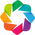

In [8]:
import holoviews as hv
hv.extension('bokeh')

In [9]:
fig = hv.Curve((df.L,df.Z), label='Zb dx=0.5m').options(show_grid=True, ylabel='elevation[m]', xlabel='distance[m]' ,color='k') \
* hv.Scatter((Ls2, Zip2), label='Zb dx=10m').options(color='r',size=6) \
* hv.Scatter((Ls3, Zip3), label='Zb dx=100m').options(color='g',size=6) \
* hv.Curve((Ls1, Zip1 + hc1), label='dx=0.5m' ).options(color='b') \
* hv.Curve((Ls2, Zip2 + hc2), label='dx=10m').options(color='r') \
* hv.Curve((Ls3, Zip3 + hc3), label='dx=100m').options(color='g')

In [10]:
figo = fig.options(width=500, legend_position='bottom_right')
d = hv.save(figo, 'USSdx.html')
figo 

:Overlay
   .Curve.Zb_dx_equals_0_full_stop_5m :Curve   [x]   (y)
   .Scatter.Zb_dx_equals_10m          :Scatter   [x]   (y)
   .Scatter.Zb_dx_equals_100m         :Scatter   [x]   (y)
   .Curve.Dx_equals_0_full_stop_5m    :Curve   [x]   (y)
   .Curve.Dx_equals_10m               :Curve   [x]   (y)
   .Curve.Dx_equals_100m              :Curve   [x]   (y)

In [11]:
figo2 = fig.options(xlim=(3050, 3350), ylim=(7, 12), width=700, height=600, legend_position='right')
d = hv.save(figo2, 'USSdx2.html')
figo2

:Overlay
   .Curve.Zb_dx_equals_0_full_stop_5m :Curve   [x]   (y)
   .Scatter.Zb_dx_equals_10m          :Scatter   [x]   (y)
   .Scatter.Zb_dx_equals_100m         :Scatter   [x]   (y)
   .Curve.Dx_equals_0_full_stop_5m    :Curve   [x]   (y)
   .Curve.Dx_equals_10m               :Curve   [x]   (y)
   .Curve.Dx_equals_100m              :Curve   [x]   (y)